cuda
20


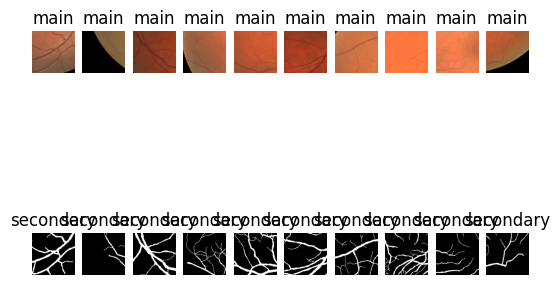

In [15]:
import os
import glob
import PIL.Image as Image
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import random
import numpy as np
import torchvision.transforms as TF
import torch.nn.functional as F
from IPython.display import clear_output

from retinal_loaders import DRIVEDataLoader
from Unet_architecture import UNet2, UNet


        

class PATCH_DRIVEDataLoader(torch.utils.data.Dataset):
    def __init__(self, train=True, transforms=None,crop_size=None, data_path='/dtu/datasets1/02516/DRIVE', window_size=(128,128)):
        'Initialization'
        self.transforms = transforms
        self.is_train_loader = train
        
        self.crop_size = crop_size
        
        
        
        if train:
            # Training data
            image_folder = os.path.join(data_path, 'training', 'images')
            vessel_mask_folder = os.path.join(data_path, 'training', '1st_manual')  # Vessel masks for training
            fov_mask_folder = os.path.join(data_path, 'training', 'mask')  # Field of view masks for training
        else:
            # Test data
            image_folder = os.path.join(data_path, 'test', 'images')
            fov_mask_folder = os.path.join(data_path, 'test', 'mask')  # Only FOV masks are available for test set
            vessel_mask_folder = None  # No vessel mask for test set

        # Get image paths
        self.image_paths = sorted(glob.glob(os.path.join(image_folder, '*.tif')))

        # Get vessel mask paths if available (for training)
        if vessel_mask_folder:
            self.vessel_mask_paths = sorted(glob.glob(os.path.join(vessel_mask_folder, '*.gif')))
        else:
            self.vessel_mask_paths = [None] * len(self.image_paths)  # No vessel mask for test set

        # Get FOV mask paths
        self.fov_mask_paths = sorted(glob.glob(os.path.join(fov_mask_folder, '*.gif')))
        
        # Check if we have found the files
        if len(self.image_paths) == 0 or len(self.fov_mask_paths) == 0:
            raise ValueError(f"No images or masks found in the provided path: {data_path}")

        if train and len(self.image_paths) != len(self.vessel_mask_paths):
            raise ValueError("Mismatch between the number of images and vessel masks in the training set.")

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def transform(self, image, vessel_mask, fov_mask):
        
        out_image = image
        out_vessel_mask = vessel_mask
        out_fov_mask = fov_mask
        
        
        
        if not self.is_train_loader:
            resize_params = np.array(out_image).shape
            resize_x = resize_params[0] / self.crop_size[0]
            resize_y = resize_params[1] / self.crop_size[1]
            resize_x = (int)(np.floor(resize_x) * self.crop_size[0])
            resize_y = (int)(np.floor(resize_y) * self.crop_size[1])
            
            out_image = TF.functional.resize(out_image, size=[resize_x, resize_y])
            out_fov_mask = TF.functional.resize(out_fov_mask, size=[resize_x, resize_y])
        
        
        if self.is_train_loader:
            if self.crop_size != None:
                i, j, h, w = TF.RandomCrop.get_params(
                    image, output_size=self.crop_size)
                out_image =         TF.functional.crop(out_image,      i,j,h,w)
                if vessel_mask != None:
                    out_vessel_mask =   TF.functional.crop(out_vessel_mask,i,j,h,w)
                out_fov_mask =      TF.functional.crop(out_fov_mask,   i,j,h,w)
        
        if vessel_mask != None:
            vessel_mask = self.transforms(out_vessel_mask)
        
        return self.transforms(out_image), vessel_mask, self.transforms(out_fov_mask)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        vessel_mask_path = self.vessel_mask_paths[idx]
        fov_mask_path = self.fov_mask_paths[idx]

        # Load the image
        image = Image.open(image_path)

        # Load the vessel mask (if available, i.e., for training)
        vessel_mask = Image.open(vessel_mask_path) if vessel_mask_path else None

        # Load the FOV mask
        fov_mask = Image.open(fov_mask_path)

        image, vessel_mask, fov_mask = self.transform(image, vessel_mask, fov_mask)
        # Apply transforms to the image and masks
        # if self.transform:
        #     image = self.transform(image)
        #     fov_mask = self.transform(fov_mask)
        #     if vessel_mask:
        #         vessel_mask = self.transform(vessel_mask)

        # Apply FOV mask to both image and vessel mask if available
        if self.is_train_loader:
            image = image * fov_mask
            vessel_mask = vessel_mask * fov_mask
            return image, vessel_mask  # Return both image and vessel mask for training

        # For test set, return only the FOV-masked image and FOV mask
        return image, fov_mask


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Define transformations to resize and convert images to tensors
transform = TF.Compose([
    # transforms.Resize((size, size)), 
    TF.ToTensor()
])

# Create DataLoader for the dataset
batch_size = 10

size = 128

# Create the full training set
full_trainset = PATCH_DRIVEDataLoader(train=True, transforms=transform, crop_size=(size,size))
full_test_set = PATCH_DRIVEDataLoader(train=False, transforms=transform, crop_size=(size,size))

print(len(full_test_set))


loader = DataLoader(full_trainset, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = DataLoader(full_test_set, batch_size=batch_size, shuffle=False, num_workers=1)

transform = TF.ToPILImage()
images = next(iter(loader))
for i in range(batch_size):
    
    main = transform(images[0][i])
    secondary = transform(images[1][i])
    
    plt.subplot(2, batch_size, i+1)
    plt.imshow(main)
    plt.title('main')
    plt.axis('off')

    plt.subplot(2, batch_size, i+batch_size+1)
    plt.imshow(secondary, cmap='gray')
    plt.title('secondary')
    plt.axis('off')
plt.show()



Training a network

In [2]:
def train(model, opt, loss_fn, epochs, train_loader, test_loader):
    X_test, Y_test = next(iter(train_loader))

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights
            opt.zero_grad(set_to_none=True)
            # calculate metrics to show the user
            avg_loss += loss.item() / len(train_loader)
        print(' - loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = torch.sigmoid(model(X_test.to(device))).detach().cpu()
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_test[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
            plt.subplot(3, 6, k+13)
            plt.imshow(Y_test[k, 0].detach().cpu(), cmap='gray')
            plt.title('Ground Truth')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

In [3]:
def bce_loss(y_real, y_pred):
    return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))

def focal_loss(y_real, y_pred, alpha=0.25, gamma=2.0):
    """
    Focal Loss for binary classification.
    """
    # Apply sigmoid to logits to get probabilities
    
    
    # Flatten the tensors
    y_real = y_real.reshape(-1)
    y_pred = y_pred.reshape(-1)

    # Compute the binary cross-entropy (BCE) loss
    loss = F.binary_cross_entropy_with_logits(y_pred, y_real, reduction="none")

    # Compute the focal loss factor (1 - pt)^gamma
    pt = torch.where(y_real == 1, y_pred, 1 - y_pred)  # p_t = y_pred for positive class, 1-y_pred for negative class
    focal_weight = (1 - pt) ** gamma

    # Apply alpha weighting for the minority class
    alpha_weight = torch.where(y_real == 1, alpha, 1 - alpha)

    # Final focal loss
    loss = focal_weight * alpha_weight * loss

    return loss.mean()

gamma = 2
def focal_loss(y_real, y_pred,gamma):
    y_pred_sig = torch.sigmoid(y_pred)
    term = (1-y_pred_sig)**gamma * y_real * torch.log(y_pred_sig) + (1-y_real) * torch.log(1-y_pred_sig)
    return (-term.sum())

def dice_loss(y_real, y_pred, epsilon=1e-6):
    y_pred = torch.sigmoid(y_pred)
    y_real = y_real.float()
    
    # Flatten spatial dimensions (keep batch dimension)
    y_real_flat = y_real.view(y_real.size(0), -1)
    y_pred_flat = y_pred.view(y_pred.size(0), -1)
    
    # Compute per-sample Dice coefficient
    intersection = (y_real_flat * y_pred_flat).sum(dim=1)
    union = y_real_flat.sum(dim=1) + y_pred_flat.sum(dim=1)
    dice_coeff = (2. * intersection + epsilon) / (union + epsilon)
    
    # Compute Dice loss
    dice_loss = 1. - dice_coeff
    return dice_loss.mean()

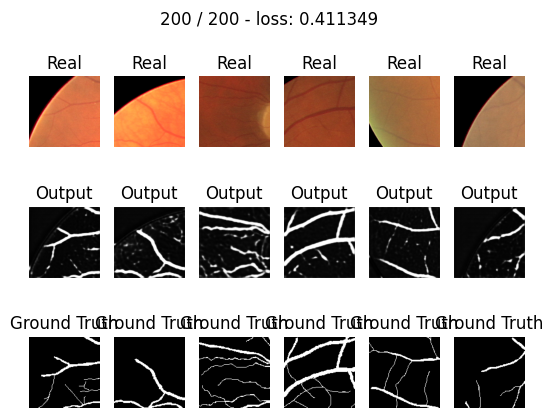

In [4]:
import torch.optim as optim
model = UNet2(parameter_count=128).to(device)

train(model, optim.Adam(model.parameters(), 0.00001, weight_decay=0.001), dice_loss, 200, loader, test_loader)


Examine the outputs

(10, 1, 512, 512)
4
4
tensor(17882.6133)
tensor(58061.8398)
tensor(97345.5781)
tensor(115428.1953)
tensor(157314.6719)
tensor(198783.4688)
tensor(247767.1875)
tensor(295521.1562)
tensor(333491.7500)
tensor(375367.1250)
tensor(425425.7188)
tensor(470164.8750)
tensor(488173.1562)
tensor(525456.5000)
tensor(567565.9375)
tensor(585981.6875)
tensor(585981.6875)


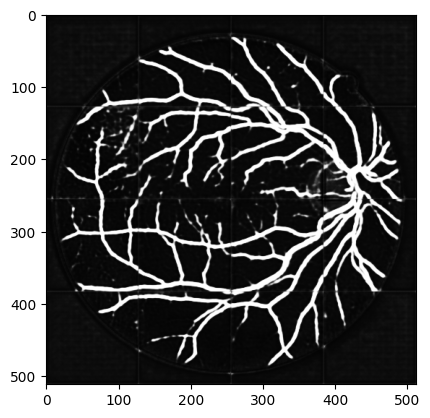

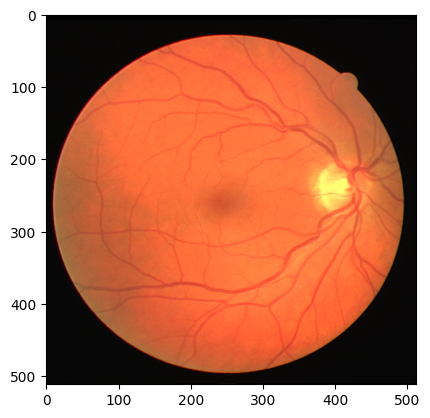

In [17]:



def evaluate(image, target, model, loss_fn, crop_size,device='cpu'):
    image = image.to(device)  # Move input to the correct device
    target = target.to(device)  # Move target to the correct device
    model = model.to(device)
    
    image_size = np.array(target.cpu()).shape # image is a tensor of shape (B, C, W, H)
    print(image_size)
    x_splits = (int)(image_size[2] / crop_size[0]) 
    y_splits = (int)(image_size[3] / crop_size[1])
    
    batch_size = image_size[0]
    
    output_images = torch.zeros(image_size)
    
    avg_loss = 0
    model.eval()
    x_size = crop_size[0]
    y_size = crop_size[1]
    
    
    print(x_splits)
    print(y_splits)
    for x in range(x_splits):
        for y in range(x_splits):
            main_image = TF.functional.crop(image,    x*x_size,y*y_size,x_size,y_size)
            
            pred = model(main_image)
            loss = torch.sigmoid(pred).detach().cpu()
            

            output_images[:, :, x*x_size:x*x_size+x_size, y*y_size: y*y_size+y_size] = loss
            avg_loss += loss.sum() / batch_size*x_splits*y_splits
            print(avg_loss)
            del main_image
    
    return output_images ,avg_loss

# model = torch.jit.load('model.pt')
# model.eval()

model.eval()
image = next(iter(test_loader))

main = image[0][:]
secondary = image[1][:]

images, loss = evaluate(main, secondary, model, focal_loss, crop_size=(size,size),device="cuda" )
print(loss)
plt.imshow(transform(images[1]),cmap="gray")
plt.show()
plt.imshow(transform(main[1]))
plt.show()